# Polar amplification in simple models

### Work in progress!!

____________

## 1. Review of polar warming in the 1D EBM with ice albedo feedback
____________

Previously we derived the equation for the one-dimensional EBM with diffusive heat transport and an interactive snow and ice line:

$$ C \frac{\partial T}{\partial t} = (1-\alpha) ~ Q - \left( A + B~T \right) + \frac{D}{\cos⁡\phi } \frac{\partial }{\partial \phi} \left(   \cos⁡\phi  ~ \frac{\partial T}{\partial \phi} \right) $$


The surface albedo depends on temperature and is larger wherever the temperature is below some threshold $T_f$:

$$ \alpha\left(\phi, T(\phi) \right) = \left\{\begin{array}{ccc} 
\alpha_0 + \alpha_2 P_2(\sin\phi) & ~ & T(\phi) > T_f  & \text{(no ice)} \\
a_i & ~ & T(\phi) \le T_f & \text{(ice-covered)} \\
\end{array} \right. $$

where $P_2(\sin\phi) = \frac{1}{2}\left( 3\left(\sin\phi\right)^2 - 1 \right) $ is the second Legendre polynomial.

We chose the following parameter values, which seems to give a reasonable fit to the observed **annual mean temperature and energy budget**:

- $ A = 210 ~ \text{W m}^{-2}$ emission at 0$^\circ$C
- $ B = 2 ~ \text{W m}^{-2}~^\circ\text{C}^{-1} $ increase in emission per degree, related to net longwave climate feedback
- $ D = 0.55 ~ \text{W m}^{-2}~^\circ\text{C}^{-1} $ thermal diffusivity of the climate system
- $ T_f=-10^\circ\textrm{C} $ freezing temperature
- $ \alpha_0 = 0.3 $ global-mean albedo
- $ \alpha_2 = 0.078 $ albedo spatial dependence
- $ a_i = 0.62 $ ice albedo

We then solved the EBM with the variable snow/ice line in `climlab`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

/opt/anaconda3/lib/python3.9/site-packages/climlab/radiation/cam3/cam3.py:60: UserWarning: Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.')


In [2]:
#  for convenience, set up a dictionary with our reference parameters
param = {'D':0.55, 'A':210, 'B':2, 'a0':0.3, 'a2':0.078, 'ai':0.62, 'Tf':-10.}
model1 = climlab.EBM_annual(name='EBM with interactive ice line',
                            num_lat=180, 
                            **param)
print(model1)

climlab Process of type <class 'climlab.model.ebm.EBM_annual'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
The subprocess tree: 
EBM with interactive ice line: <class 'climlab.model.ebm.EBM_annual'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   albedo: <class 'climlab.surface.albedo.StepFunctionAlbedo'>
      iceline: <class 'climlab.surface.albedo.Iceline'>
      warm_albedo: <class 'climlab.surface.albedo.P2Albedo'>
      cold_albedo: <class 'climlab.surface.albedo.ConstantAlbedo'>
   SW: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>
   diffusion: <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>



In [3]:
# Integrate out to equilibrium.
model1.integrate_years(10)
#  Check for energy balance
print(climlab.global_mean(model1.net_radiation))

Integrating for 900 steps, 3652.4220000000005 days, or 10 years.
Total elapsed time is 9.999999999999863 years.
1.2815863596263072e-05


And added a small radiative forcing to represent a doubling of CO$_2$.

In [4]:
deltaA = 4.

#  Clone existing model:
model2 = climlab.process_like(model1)

#  Now change the longwave parameter:
model2.subprocess['LW'].A = param['A'] - deltaA
#  and integrate out to equilibrium again
model2.integrate_years(5, verbose=False)

# Now another CO2 doubling
model3 = climlab.process_like(model1)
model3.subprocess['LW'].A = param['A'] - 2*deltaA
model3.integrate_years(5, verbose=False)

Text(0.5, 1.0, 'Surface temperature change')

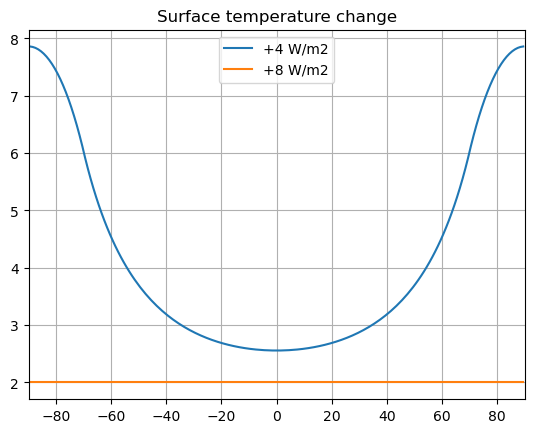

In [5]:
plt.plot(model1.lat, model2.Ts - model1.Ts, label='+4 W/m2')
plt.plot(model2.lat, model3.Ts - model2.Ts, label='+8 W/m2')
plt.xlim(-90, 90)
plt.grid()
plt.legend()
plt.title('Surface temperature change')

We found that the warming is **polar-amplified** so long as ice is present. In the ice-free regime, warming is uniform.

Is this result model specific? Is polar amplification possible in the absence of ice retreat?

Let's find out!

____________
<a id='section6'></a>

## 2. A Moist EBM
____________

We could have chosen to diffusive moist static energy rather than temperature. In this case, the governing equation for the EBM becomes

$$ C \frac{\partial T}{\partial t} = (1-\alpha) ~ Q - \left( A + B~T \right) + \frac{D}{\cos⁡\phi } \frac{\partial }{\partial \phi} \left(   \cos⁡\phi  ~ \frac{\partial h}{\partial \phi} \right) $$


Moist static energy, $h$, is given in units of temperature

$$ h = T + \frac{L_v}{c_p}\textrm{RH}q_s $$

where $L_v$ is latent heat of vaporization, $c_p$ is specific heat at constant pressure, RH is relative humidity, and $q_s(T)$ is saturation specific humidity. The second term thus represents the latent energy associated with water vapor.

In [6]:
# set up a dry EBM and swap out the diffusion subprocess
moist = climlab.EBM_annual(name='EBM with interactive ice line',
                            num_lat=180, 
                            D=0.55, 
                            A=210., 
                            B=2.)
diff = climlab.dynamics.MeridionalMoistDiffusion(state=moist.state, timestep=moist.timestep)
moist.add_subprocess('diffusion', diff)
print(moist)

climlab Process of type <class 'climlab.model.ebm.EBM_annual'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
The subprocess tree: 
EBM with interactive ice line: <class 'climlab.model.ebm.EBM_annual'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   albedo: <class 'climlab.surface.albedo.P2Albedo'>
   SW: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>
   diffusion: <class 'climlab.dynamics.meridional_moist_diffusion.MeridionalMoistDiffusion'>



In [7]:
# Integrate out to equilibrium.
moist.integrate_years(10)
#  Check for energy balance
print(climlab.global_mean(moist.net_radiation))

#  Clone existing model:
moist2 = climlab.process_like(moist)
#  Now change the longwave parameter:
moist2.subprocess['LW'].A = param['A'] - deltaA
#  and integrate out to equilibrium again
moist2.integrate_years(10, verbose=False)

Integrating for 900 steps, 3652.4220000000005 days, or 10 years.
Total elapsed time is 9.999999999999863 years.
7.069415305185912e-07


Text(0.5, 1.0, 'Surface temperature change')

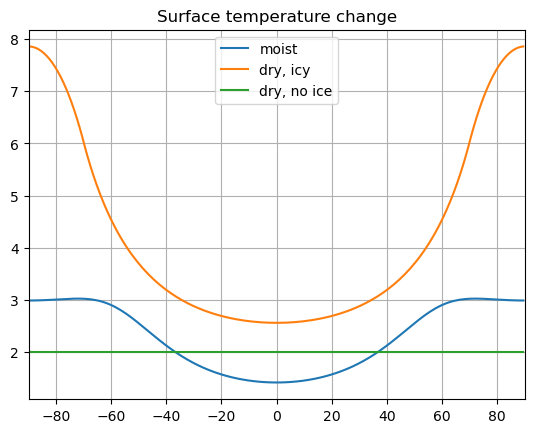

In [8]:
plt.plot(model1.lat, moist2.Ts - moist.Ts, label='moist')
plt.plot(model2.lat, model2.Ts - model1.Ts, label='dry, icy')
plt.plot(model2.lat, model3.Ts - model2.Ts, label='dry, no ice')
plt.xlim(-90, 90)
plt.grid()
plt.legend()
plt.title('Surface temperature change')

The warming is polar-amplified, though weaker in magnitude than the dry EBM with ice.

Why? Because atmospheric energy transport increases with radiative forcing in the moist EBM.

To gain insight into why the addition of latent energy transport led to this behavior, let's look at a two-layer model.

____________
<a id='section6'></a>

## 2. Grey model with surface and atmosphere layers
____________

The following code creates a two-layer model with a grey radiation atmosphere, annual-mean insolation, and surface sensible heat flux---including evaporation from the surface. It does **not** include heat transport by default.

In [9]:
twolayer = climlab.GreyRadiationModel(num_lev=1, num_lat=180)
insolation = climlab.radiation.AnnualMeanInsolation(domains=twolayer.Ts.domain)
twolayer.add_subprocess('insolation', insolation)
twolayer.subprocess.SW.flux_from_space = twolayer.subprocess.insolation.insolation
print(twolayer)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
  Tatm: (180, 1) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [10]:
#  add a fixed relative humidity process
#  (will only affect surface evaporation)
h2o = climlab.radiation.ManabeWaterVapor(state=twolayer.state, **twolayer.param)
twolayer.add_subprocess('H2O', h2o)

#  Add surface heat fluxes
shf = climlab.surface.SensibleHeatFlux(state=twolayer.state, Cd=3E-4)
lhf = climlab.surface.LatentHeatFlux(state=twolayer.state, Cd=3E-4)
# couple water vapor to latent heat flux process
lhf.q = h2o.q
twolayer.add_subprocess('SHF', shf)
twolayer.add_subprocess('LHF', lhf)

print(twolayer)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
  Tatm: (180, 1) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



In [11]:
# Integrate out to equilibrium.
twolayer.integrate_years(5)
#  Check for energy balance
print(climlab.global_mean(twolayer.ASR-twolayer.OLR))

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
-2.967640751927588e-12


Text(0.5, 1.0, 'Temperature')

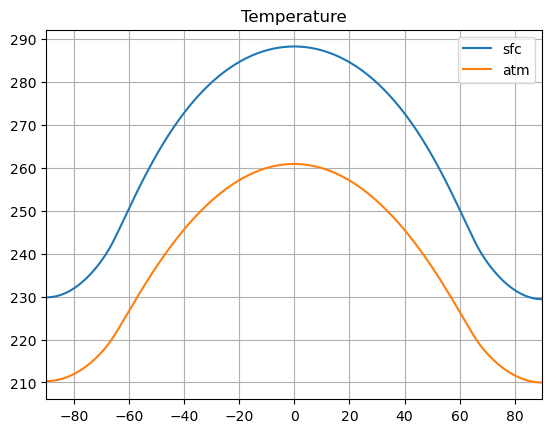

In [12]:
plt.plot(twolayer.lat, twolayer.Ts, label='sfc')
plt.plot(twolayer.lat, twolayer.Tatm, label='atm')
plt.xlim(-90, 90)
plt.grid()
plt.legend()
plt.title('Temperature')

In [13]:
#  Clone existing model:
twolayer2 = climlab.process_like(twolayer)
#  Now change the longwave absorptivity to represent an increase in greenhouse gases:
twolayer2.subprocess['LW'].absorptivity = twolayer.subprocess['LW'].absorptivity*1.1
#  and integrate out to equilibrium again
twolayer2.integrate_years(10, verbose=False)

Text(0.5, 1.0, 'Temperature change')

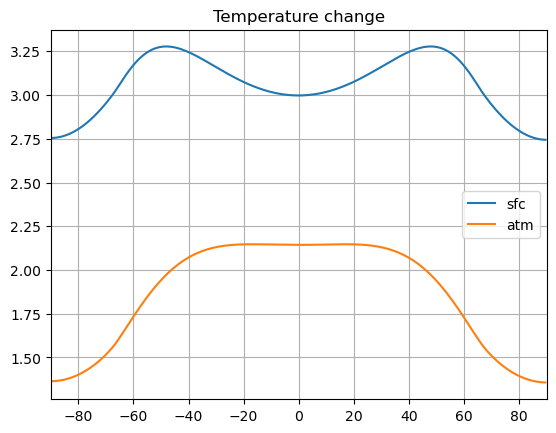

In [14]:
plt.plot(twolayer.lat, twolayer2.Ts - twolayer.Ts, label='sfc')
plt.plot(twolayer.lat, twolayer2.Tatm - twolayer.Tatm, label='atm')
plt.xlim(-90, 90)
plt.grid()
plt.legend()
plt.title('Temperature change')

No polar amplification with no heat transport.

With evaporation, the atmosphere has warmed more in the tropics than in the poles. What do you expect to happen with the addition of heat transport? 

### Now with meridional heat transport

In [15]:
difftwolayer = climlab.process_like(twolayer)
# thermal diffusivity in W/m**2/degC
D = 0.6
# kinematic diffusivity in m**2/s
# (this model expects diffusivity in different units, but we can convert from thermal to kinematic diffusivity)
K = D / difftwolayer.Tatm.domain.heat_capacity * const.a**2
d = climlab.dynamics.MeridionalDiffusion(K=K, state={'Tatm': difftwolayer.Tatm}, **difftwolayer.param)
difftwolayer.add_subprocess('diffusion', d)
print(difftwolayer)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
  Tatm: (180, 1) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>
   diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>



In [16]:
# Integrate out to equilibrium.
difftwolayer.integrate_years(5)
#  Check for energy balance
print(climlab.global_mean(difftwolayer.ASR-difftwolayer.OLR))

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 9.998844602294039 years.
-6.343065652548722e-12


Let's check the heat transport.

In [17]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

# Integrate one more year so can easily take time averages over last year
difftwolayer.integrate_years(1)

Rtoa = np.squeeze(difftwolayer.timeave['ASR'] - difftwolayer.timeave['OLR'])
difftwolayer_transport = inferred_heat_transport(Rtoa, difftwolayer.lat)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 10.998181480672276 years.


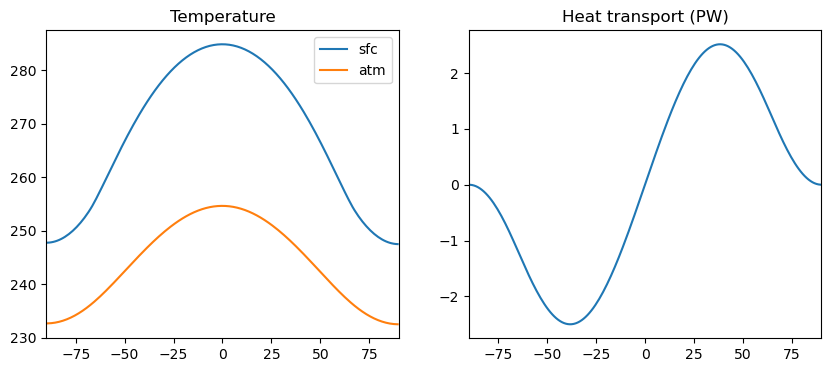

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(difftwolayer.lat, difftwolayer.Ts, label='sfc')
ax[0].plot(difftwolayer.lat, difftwolayer.Tatm, label='atm')
ax[0].legend()
ax[0].set_title('Temperature')
ax[1].plot(difftwolayer.lat, difftwolayer_transport)
ax[1].set_title('Heat transport (PW)')
for a in [ax[0],ax[1]]:
    a.set_xlim(-90,90)

In [19]:
#  Clone existing model:
difftwolayer2 = climlab.process_like(difftwolayer)
#  Now change the longwave absorptivity to represent an increase in greenhouse gases:
difftwolayer2.subprocess['LW'].absorptivity = difftwolayer.subprocess['LW'].absorptivity*1.1
#  and integrate out to equilibrium again
difftwolayer2.integrate_years(10, verbose=False)
# and calculate transport
difftwolayer2.integrate_years(1)
Rtoa = np.squeeze(difftwolayer2.timeave['ASR'] - difftwolayer2.timeave['OLR'])
difftwolayer2_transport = inferred_heat_transport(Rtoa, difftwolayer2.lat)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 21.996362961344552 years.


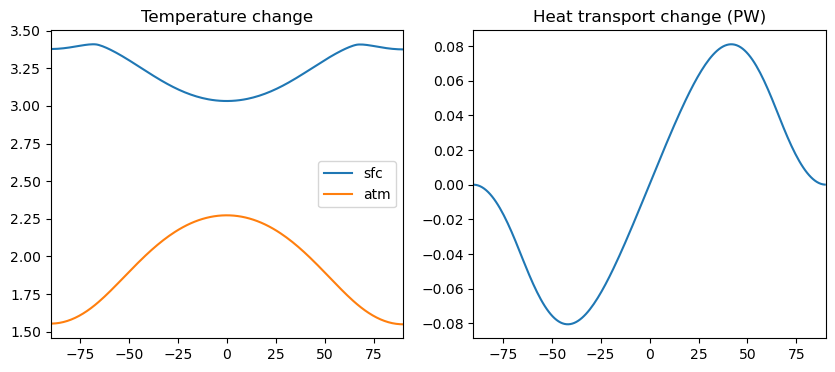

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(difftwolayer2.lat, difftwolayer2.Ts-difftwolayer.Ts, label='sfc')
ax[0].plot(difftwolayer2.lat, difftwolayer2.Tatm-difftwolayer.Tatm, label='atm')
ax[0].legend()
ax[0].set_title('Temperature change')
ax[1].plot(difftwolayer2.lat, difftwolayer2_transport-difftwolayer_transport)
ax[1].set_title('Heat transport change (PW)')
for a in [ax[0],ax[1]]:
    a.set_xlim(-90,90)

What do we see? Poleward heat transport has increased, and surface temperature chagne is polar-amplified. If this was in fact due to the addition of evaporation, then we should be able to remove that process and return to the non-polar-amplified case.

Let's find out!

In [21]:
diffnoevap = climlab.process_like(difftwolayer)
diffnoevap.remove_subprocess('LHF')
diffnoevap.integrate_years(5)

# Now clone and change the longwave absorptivity to represent an increase in greenhouse gases:
diffnoevap2 = climlab.process_like(difftwolayer2)
diffnoevap2.remove_subprocess('LHF')
diffnoevap2.integrate_years(5, verbose=False)

# and calculate transport
diffnoevap.integrate_years(1)
Rtoa = np.squeeze(diffnoevap.timeave['ASR'] - diffnoevap.timeave['OLR'])
diffnoevap_transport = inferred_heat_transport(Rtoa, diffnoevap.lat)
diffnoevap2.integrate_years(1)
Rtoa = np.squeeze(diffnoevap2.timeave['ASR'] - diffnoevap2.timeave['OLR'])
diffnoevap2_transport = inferred_heat_transport(Rtoa, diffnoevap2.lat)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 15.997603781819295 years.
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 16.996940660197534 years.
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 27.99512214086981 years.


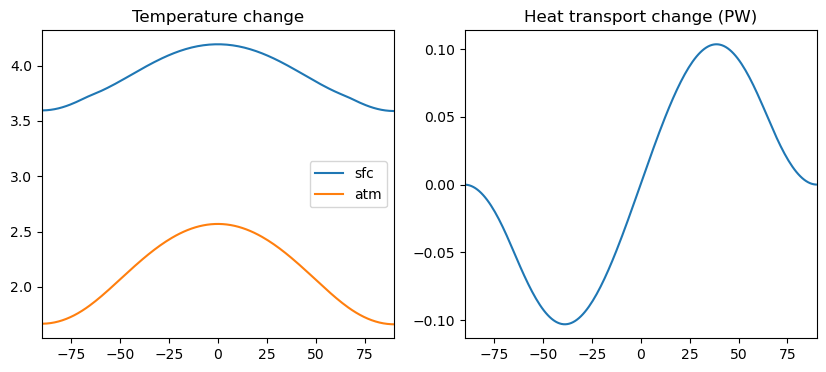

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(diffnoevap.lat, diffnoevap2.Ts-diffnoevap.Ts, label='sfc')
ax[0].plot(diffnoevap.lat, diffnoevap2.Tatm-diffnoevap.Tatm, label='atm')
ax[0].legend()
ax[0].set_title('Temperature change')
ax[1].plot(diffnoevap.lat, diffnoevap2_transport-diffnoevap_transport)
ax[1].set_title('Heat transport change (PW)')
for a in [ax[0],ax[1]]:
    a.set_xlim(-90,90)

Indeed we see that neither the surface temperature nor the atmospheric temperature are polar-amplified, despite the (very small) increase in heat transport. It is specifically the addition of water vapor that leads to polar amplification in the EBM given a radiative forcing.

____________

## Credits

This notebook is part of The Climate Laboratory, an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany. It has been modified by [Nicole Feldl](http://nicolefeldl.com), UC Santa Cruz.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________